In [0]:
%matplotlib inline 
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt
import multiprocessing

# Install PyTorch

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [0]:
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
import cv2

In [0]:
class FaceDetection():
    
    def __init__(self, path2img = 'figures/fig.jpg', path2class = '/Users/renatobottermaiolopesrodrigues/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml'):
        
        #Load image
        self.img_original = cv2.imread(path2img)
        
        # Convert to RGB colorspace
        self.img_original = self.convertToRGB(self.img_original)
        
        # copy original image
        self.img_with_detections = np.copy(self.img_original)
        
        #convert image to gray (opencv expects gray images)
        self.gray_img = self.convertToGray(self.img_original)

        #load cascade classifier (haarcascade) training file
        self.haar_face_cascade = cv2.CascadeClassifier(path2class)

        #Detect multiscale images 
        self.faces = self.haar_face_cascade.detectMultiScale(self.gray_img, scaleFactor=1.1, minNeighbors=5);

    def number_faces(self):
        #print the number of faces found 
        print('Faces found: ', len(self.faces))

    def convertToGray(self, img):
        # Convert the RGB  image to grayscale
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    def convertToRGB(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    def detection(self):
    
        faces_crop = []
        for (x, y, w, h) in self.faces:  
            obj = self.img_with_detections[y:y + h, x:x + w]
            faces_crop.append(obj)
            cv2.rectangle(self.img_with_detections, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
        return faces_crop

In [0]:
FaceDetection = FaceDetection()

In [0]:
FaceDetection.number_faces()

Faces found:  11


In [0]:
faces_crop = FaceDetection.detection()
(img_original, img_with_detections) =  (FaceDetection.img_original, FaceDetection.img_with_detections)

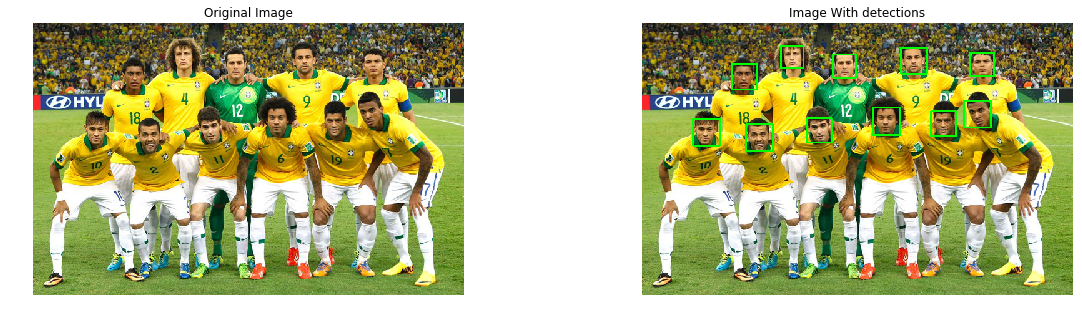

In [0]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(img_original)
plt.title('Original Image')
plt.axis('off')


plt.subplot(1,2,2)
#convert image to RGB and show image 
plt.imshow(img_with_detections)
plt.title('Image With detections')
plt.axis('off')

fig.savefig('figures/fig_detection.png')

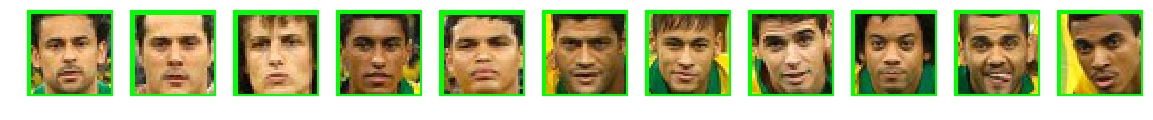

In [0]:
plt.figure(figsize=(20,5))
count = 1
for face in faces_crop:
    plt.subplot(1,len(faces_crop),count)
    count+=1
    plt.imshow(face)
    plt.axis('off')

In [171]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)
cpu_count = multiprocessing.cpu_count()
print('cpu_count: ', cpu_count)

GPU available: False
cpu_count:  2


In [0]:
!pip install kaggle

In [173]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

if not os.path.exists('data/'):

    auth.authenticate_user()

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

    !kaggle competitions download -c facial-keypoints-detection -p data/ && cd data && unzip training.zip && unzip test.zip
    
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [0]:
path2data = 'data/'

In [0]:
path2trainData = path2data + 'training.csv'
path2testData = path2data + 'test.csv'

In [0]:
class FaceKeyPointsDataset(Dataset):

    def __init__(self, X, y, transforms=None):
        
        self.transform = transforms    
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        image = self.X[index]
        keypoints = self.y[index]        
        
        if self.transform:
            image = self.transform(image)
            
        return image, keypoints

    def __len__(self):
        return len(self.X)

In [0]:
class ToTensor(object):

    def __call__(self, image):
        # imagem numpy: C x H x W
        # imagem torch: C X H X W
                    
        image = image.transpose((0, 1, 2))
        return torch.from_numpy(image)

In [0]:
class CloneArray(object):
    
    def __call__(self, image):
        image = image.repeat(3, axis=0)
        return image

In [0]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

In [0]:
data_transforms = {
    'train': transforms.Compose([
        CloneArray(),
        ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        CloneArray(),
        ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

In [0]:
def get_data(path2data, is_test = False):

    df = pd.read_csv(path2data)
    df = df.dropna()

    df['Image'] = df['Image'].apply(lambda img:  np.fromstring(img, sep = ' '))
    X = np.vstack(df['Image'].values)
    X = X / 255.   # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, 1, 96, 96) # return each images as 1 x 96 x 96

    if not is_test:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48 
        y = y.astype(np.float32)
    else:
        y = np.zeros((len(X)))

    return X, y

In [0]:
X_train, y_train = get_data(path2trainData)
X_test, y_test = get_data(path2testData, is_test=True)

In [0]:
dsets = {
    'train': FaceKeyPointsDataset(X_train, y_train, transforms=data_transforms['train']),
    'valid': FaceKeyPointsDataset(X_train, y_train, transforms=data_transforms['valid']),
    'test':  FaceKeyPointsDataset(X_test, y_test, transforms=data_transforms['valid']),
}

### Split train and valid set

In [0]:
batch_size = 32
random_seed = 3
valid_size = 0.2
shuffle = True

In [0]:
num_train = len(dsets['train'])
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

sampler = {'train': train_sampler,
          'valid': valid_sampler,
          'test': None}

In [0]:
def create_dataLoader(dsets, batch_size, sampler={'train': None, 'valid': None,'test': None},
                      pin_memory=False):
  
    dset_loaders = {} 
    for key in dsets.keys():
        if sampler[key] != None:
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, sampler=sampler[key], pin_memory=pin_memory)
        else:          
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle=False)

    return dset_loaders

In [0]:
dset_loaders = create_dataLoader(dsets, batch_size, sampler, pin_memory=False)

In [328]:
image, keypoints = next(iter(dset_loaders['train']))
print(image.size(), keypoints.size())

torch.Size([32, 3, 96, 96]) torch.Size([32, 30])


In [0]:
def plot_face_Keypoints(dsets, is_train = True, preds_test = [], preds_train = []):
    
    plt.figure(figsize=(20,10))
    for i in range(0, 4):
        plt.subplot(1,4,i+1)
        
        rand_img = random.randrange(0, len(dsets))
        
        X = dsets[rand_img][0].numpy()
        img = denormalize(dsets[rand_img][0].numpy())
        img = np.clip(img, 0, 1.0)
        plt.imshow(img)
        
        if is_train:
            y =  dsets[rand_img][1]
        else:
            y = preds_test.numpy()[rand_img]

        cordinates = y * 48 + 48
        
        plt.imshow(img, cmap = 'gray')
        if (len(preds_train) !=0):
            plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
            cordinates_train = preds_train[rand_img].numpy()
            cordinates_train = cordinates_train*48 + 48
            plt.scatter(cordinates_train[::2], cordinates_train[1::2], marker='o', c='r', s=10)

        plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
        plt.title('Sample n {}'.format(rand_img))
        plt.axis('off')

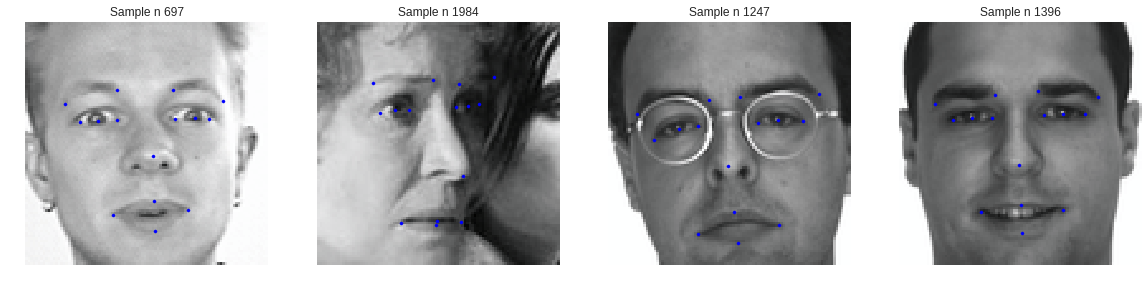

In [330]:
plot_face_Keypoints(dsets['train'])

In [331]:
nb_out = 30
print('Number of outputs: {}'.format(nb_out))

Number of outputs: 30


# Create model

In [0]:
class MyConvNet(nn.Module):
    
    def __init__(self):
        super(MyConvNet, self).__init__()
        
        self.conv = nn.Conv2d(3, 1, (5, 5), padding=0, bias=True)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d((5, 5))
        
        
        self.fc = torch.nn.Sequential(torch.nn.Linear(324,128),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.Linear(128, 64),
                                          torch.nn.ReLU(inplace=True),
                                          torch.nn.Linear(64,  nb_out))
        
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.max_pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        return x

In [0]:
model = MyConvNet()

if use_gpu:
    model.cuda() 

In [390]:
print(model)

MyConvNet(
  (conv): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): Linear(in_features=324, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=30, bias=True)
  )
)


In [0]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, ( inputs, labels) in enumerate(loader):     
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.data[0]
            
    return (total_loss / i)

In [0]:
def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    
    patience_count= 0
    ii_n = len(train_loader)
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            predict = model(inputs)
            
            
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(loss.data[0])
        loss_test.append( evaluate_model(test_loader, model,loss_fn, use_gpu) )
        
        print('\nEpoch: {}  Loss Train: {}  Lost Test: {}'.format(epoch, loss_train[-1], loss_test[-1]), end='\n')
        
        #Early stopping
        if(best_test_acc > loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('\rDone!')
    return loss_train, loss_test, model 

In [0]:
loss_fn = torch.nn.MSELoss()
optimizer =  optim.RMSprop(model.fc.parameters(), lr=1e-3)
num_epochs = 20
patience = 2

In [0]:
params = {'model' : model, 
        'train_loader':dset_loaders['train'],
         'test_loader':dset_loaders['valid'],
         'num_epochs': num_epochs,
         'loss_fn': loss_fn,
         'optimizer': optimizer, 
         'patience': patience 
         }

In [0]:
loss_train, loss_test, model = train(**params)

In [0]:
def predict(model, dset_loaders, use_gpu = False):

    predictions = []
    model.train(False)  # Set model to evaluate mode
    ii_n = len(dset_loaders)
    for ii, (image, labels) in enumerate(dset_loaders):

        if use_gpu:
            image = Variable(image.cuda())
        else:
            image = Variable(image)
        outputs = model(image)
        predictions.append(outputs.data.cpu())
        print('\rpredict: {}/{}'.format(ii, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return torch.cat(predictions, 0)

# Evaluate results

In [397]:
preds_test = predict(model, dset_loaders['test'], use_gpu)
preds_train = predict(model, dset_loaders['train'],use_gpu)

predict: 55/55 ok
predict: 53/53 ok


In [398]:
(preds_test.shape, preds_train.shape)

(torch.Size([1783, 30]), torch.Size([1712, 30]))

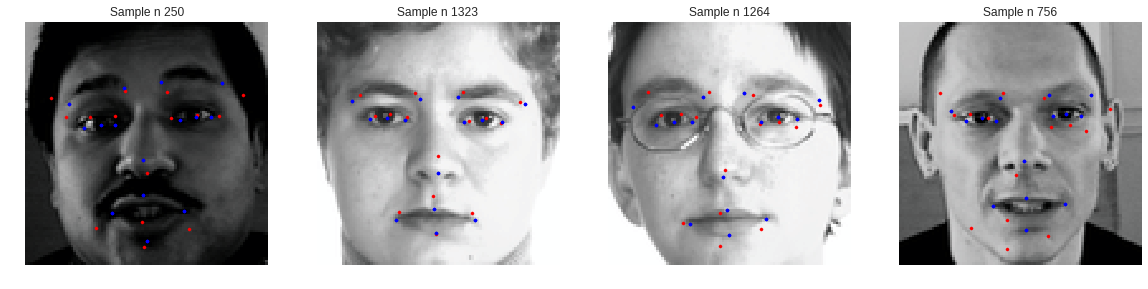

In [408]:
plot_face_Keypoints(dsets['train'],  preds_train = preds_train)

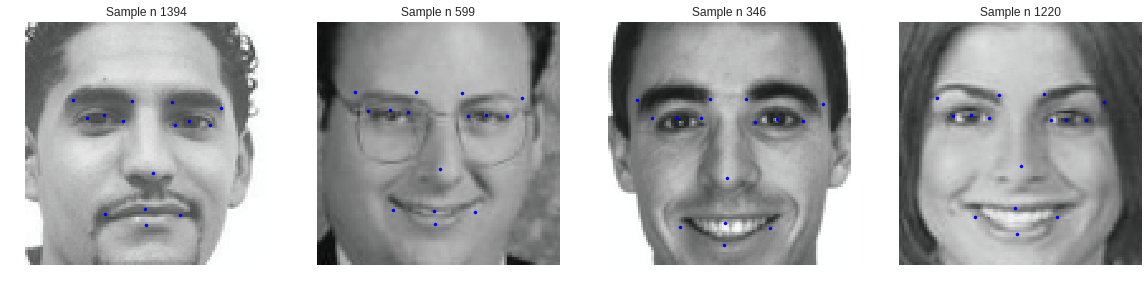

In [407]:
plot_face_Keypoints(dsets['test'], is_train= False,  preds_test = preds_test)

## Generate submission file

In [0]:
id_lookup_frame = pd.read_csv(path2data + "IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [0]:
y_test= preds_test.numpy() * 48  + 48
columns = dsets['train'].columns[:-1]

In [0]:
def generate_output_submission(y_test, columns, filename = "result.csv"):
    y_res = []
    j = 0
    k = 0
    m = 0
    for i in range(1, len(y_test)+1):
        img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
        if img.shape[0] == 30:
            y_res += list(y_test[i-1,:])
            j += 30
        else:
            slice_img = y_test[i-1, :]
            y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
            k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
    y_res = np.array(y_res)

    
    result_dict = {
    "RowId": range(1,y_res.shape[0]+1),
    "Location": y_res
    }
    result_df = pd.DataFrame(result_dict, )
    result_df.to_csv(filename, index=False, columns=["RowId", "Location"])
    print('Done!')

In [0]:
generate_output_submission(y_test, columns)

Done!
